## Preliminary Setup

In [15]:
import numpy as np

import datautils as du
import plotutils as pu
import s4gutils

dataDir = "./data/"
s4gdata = du.ReadCompositeTable(dataDir+"s4gbars_table.dat", columnRow=18, dataFrame=True)
nDisksTotal = len(s4gdata.name)

# paths for locating data, saving plots, etc.
baseDir = "/Users/erwin/Documents/Working/Paper-s4gbars/"
plotDir = baseDir + "plots/"
simDir = "./data/"
# to save PDF versions of figures, set savePlots = True
savePlots = False


# axis labels, etc., for plots
xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xtfgas = r"$\log \: (M_{\rm HI} / M_{\star})$"
xtgmr = r"$g - r$"
ytfbar = r"Bar Fraction $f_{\rm bar}$"
ytbarsize_kpc = r"Bar size $a_{\rm vis}$ [kpc]"
ytbarsize_kpc_obs = r"Observed bar size $a_{\rm vis}$ [kpc]"
ytR25_kpc = r"$R_{25}$ [kpc]"


ss0 = "All galaxies"
ss1 = r"S$^{4}$G: $D \leq 25$ Mpc"
ss1b = r"S$^{4}$G: $D \leq 25$ Mpc, $\log M_{\star} \geq 8.5$"

s4g_txt = r"S$^{4}$G"
s4g_fwhm_txt = r"S$^{4}$G $\langle$FWHM$\rangle$"


In [6]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Useful functions

In [27]:
def logistic_lin( x, a, b ):
    """Calculates the standard linear logistic function (probability distribution)
    for x (which can be a scalar or a numpy array).
    """
    
    return 1.0 / (1.0 + np.exp(-(a + b*x)))


def logistic_polyn( x, params ):
    """Calculates the quadratic logistic function (probability distribution)
    for x (which can be a scalar or a numpy array).
    """
    
    order = len(params) - 1
    logit = params[0]
    for n in range(order):
        b = params[n + 1]
        logit += b * x**(n + 1)
    
    return 1.0 / (1.0 + np.exp(-logit))


def GetBarazzaData( fname ):
    """Retrieve bar fractions and total galaxy counts per bin for Barazza+2008 data
    (their Fig. 19); calculates proper binomial confidence intervals.
    """
    dlines = [line for line in open(fname) if line[0] != '#' and len(line) > 1]
    x = np.array([float(line.split()[0]) for line in dlines])
    f = np.array([float(line.split()[1]) for line in dlines])
    n = np.array([int(line.split()[2]) for line in dlines])
    n_bars = np.round(f*n)
    e_low_vect = []
    e_high_vect = []
    for i in range(len(x)):
        dummy,e_low,e_high = astrostat.Binomial(n_bars[i], n[i])
        e_low_vect.append(e_low)
        e_high_vect.append(e_high)
    return (x, f, np.array(e_low_vect), np.array(e_high_vect))


### Defining different subsamples via index vectors

Lists of integers defining indices of galaxies in Parent Disc Sample which meet various criteria
that define specific subsamples.

In [9]:
ii_dist20 = [i for i in range(nDisksTotal) if s4gdata.dist[i] <= 20]
ii_dist25 = [i for i in range(nDisksTotal) if s4gdata.dist[i] <= 25]
ii_dist20to30 = [i for i in range(nDisksTotal) if s4gdata.dist[i] > 20 and s4gdata.dist[i] <= 30]
ii_dist10to30 = [i for i in range(nDisksTotal) if s4gdata.dist[i] > 10 and s4gdata.dist[i] <= 30]
ii_dist30 = [i for i in range(nDisksTotal) if s4gdata.dist[i] <= 30.0]
ii_dist30to40 = [i for i in range(nDisksTotal) if s4gdata.dist[i] > 30 and s4gdata.dist[i] <= 40]
ii_dist40 = [i for i in range(nDisksTotal) if s4gdata.dist[i] <= 40]
ii_dist20to40 = [i for i in range(nDisksTotal) if s4gdata.dist[i] > 20 and s4gdata.dist[i] <= 40]

ii_barred = [i for i in range(nDisksTotal) if s4gdata.sma[i] > 0]
ii_unbarred = [i for i in range(nDisksTotal) if s4gdata.sma[i] <= 0]

ii_spirals = [i for i in range(nDisksTotal) if s4gdata.t_s4g[i] > -0.5]
ii_barred_spirals = [i for i in ii_spirals if i in ii_barred]
ii_unbarred_spirals = [i for i in ii_spirals if i in ii_unbarred]

ii_barred_m9to10 = [i for i in ii_barred if s4gdata.logmstar[i] >= 9.0 and s4gdata.logmstar[i] <= 10.0]
ii_barred_m9_5 = [i for i in ii_barred if s4gdata.logmstar[i] >= 9.5]
ii_barred_m9 = [i for i in ii_barred if s4gdata.logmstar[i] >= 9]

ii_bars_dp = [i for i in range(nDisksTotal) if s4gdata.sma_dp_kpc[i] > 0]


# limited sample 1: D < 25 Mpc -- 663 spirals: 373 barred, 290 unbarred
ii_all_limited1 = [i for i in ii_spirals if s4gdata.dist[i] <= 25]
ii_barred_limited1 = [i for i in ii_all_limited1 if i in ii_barred]
ii_unbarred_limited1 = [i for i in ii_all_limited1 if i not in ii_barred]


ii_SB_limited1 = [i for i in ii_all_limited1 if i in ii_barred_limited1 and s4gdata.bar_strength[i] == 1]
ii_nonSB_limited1 = [i for i in ii_all_limited1 if i not in ii_SB_limited1]
ii_SAB_limited1 = [i for i in ii_all_limited1 if i in ii_barred_limited1 and s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited1 = [i for i in ii_all_limited1 if i not in ii_SB_limited1]

# S0 only (74 S0s: 27 barred, 47 unbarred)
ii_all_limited1_S0 = [i for i in range(nDisksTotal) if s4gdata.dist[i] <= 25 and s4gdata.t_s4g[i] <= -0.5]
ii_barred_limited1_S0 = [i for i in ii_all_limited1_S0 if i in ii_barred]
ii_unbarred_limited1_S0 = [i for i in ii_all_limited1_S0 if i not in ii_barred]
ii_SB_limited1_S0 = [i for i in ii_SB_limited1 if s4gdata.t_s4g[i] <= -0.5]
ii_nonSB_limited1_S0 = [i for i in ii_nonSB_limited1 if s4gdata.t_s4g[i] <= -0.5]
ii_SAB_limited1_S0 = [i for i in ii_SAB_limited1 if s4gdata.t_s4g[i] <= -0.5]
ii_nonSAB_limited1_S0 = [i for i in ii_nonSAB_limited1 if s4gdata.t_s4g[i] <= -0.5]



# limited subsample 1m: D < 25 Mpc and log Mstar >= 8.5 -- 576 spirals: 356 barred, 220 unbarred
ii_all_limited1_m8_5 = [i for i in ii_all_limited1 if s4gdata.logmstar[i] >= 8.5]
ii_barred_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i in ii_barred]
ii_unbarred_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i not in ii_barred]
ii_SB_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i in ii_barred and s4gdata.bar_strength[i] == 1]
ii_nonSB_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i not in ii_SB_limited1_m8_5]
ii_SAB_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i in ii_barred and s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i not in ii_SB_limited1_m8_5]
# S0 only (74 S0s: 27 barred, 47 unbarred)
ii_all_limited1_m8_5_S0 = [i for i in ii_all_limited1_S0 if s4gdata.logmstar[i] >= 8.5]
ii_barred_limited1_m8_5_S0 = [i for i in ii_all_limited1_m8_5_S0 if i in ii_barred]
ii_unbarred_limited1_m8_5_S0 = [i for i in ii_all_limited1_m8_5_S0 if i not in ii_barred]
ii_SB_limited1_m8_5_S0 = [i for i in ii_all_limited1_m8_5_S0 if i in ii_barred and s4gdata.bar_strength[i] == 1]
ii_nonSB_limited1_m8_5_S0 = [i for i in ii_all_limited1_m8_5_S0 if i not in ii_SB_limited1_m8_5_S0]
ii_SAB_limited1_m8_5_S0 = [i for i in ii_all_limited1_m8_5_S0 if i in ii_barred and s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited1_m8_5_s0 = [i for i in ii_all_limited1_m8_5_S0 if i not in ii_SAB_limited1_m8_5_S0 and s4gdata.t_s4g[i]]

# mass bins for barred spirals: D <= 25 Mpc
ii_barred_limited1_m85to9 = [i for i in ii_barred_limited1_m8_5 if s4gdata.logmstar[i] < 9]
ii_barred_limited1_m9to95 = [i for i in ii_barred_limited1_m8_5 if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] < 9.5]
ii_barred_limited1_m95to10 = [i for i in ii_barred_limited1_m8_5 if s4gdata.logmstar[i] >= 9.5 and s4gdata.logmstar[i] < 10]
ii_barred_limited1_m101to103 = [i for i in ii_barred_limited1_m8_5 if s4gdata.logmstar[i] >= 10.1 and s4gdata.logmstar[i] < 10.3]
ii_barred_limited1_m103to105 = [i for i in ii_barred_limited1_m8_5 if s4gdata.logmstar[i] >= 10.3 and s4gdata.logmstar[i] < 10.5]

ii_barred_limited1_m8_5to11 = [i for i in ii_barred_limited1_m8_5 if s4gdata.logmstar[i] <= 11]



# limited subsample 2: D < 30 Mpc -- 856 galaxies: 483 barred, 373 unbarred
ii_all_limited2 = [i for i in ii_spirals if s4gdata.dist[i] <= 30]
ii_barred_limited2 = [i for i in ii_all_limited2 if i in ii_barred]
ii_unbarred_limited2 = [i for i in ii_all_limited2 if i not in ii_barred]

ii_SB_limited2 = [i for i in ii_barred_limited2 if s4gdata.bar_strength[i] == 1]
ii_nonSB_limited2 = [i for i in ii_all_limited2 if i not in ii_SB_limited2]
ii_SAB_limited2 = [i for i in ii_barred_limited2 if s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited2 = [i for i in ii_all_limited2 if i not in ii_SB_limited2]

# S0 only (74 S0s: 27 barred, 47 unbarred)
ii_all_limited2_S0 = [i for i in range(nDisksTotal) if s4gdata.dist[i] <= 30 and s4gdata.t_s4g[i] <= -0.5]
ii_barred_limited2_S0 = [i for i in ii_all_limited2_S0 if i in ii_barred]
ii_unbarred_limited2_S0 = [i for i in ii_all_limited2_S0 if i not in ii_barred]
ii_SB_limited2_S0 = [i for i in ii_SB_limited2 if s4gdata.t_s4g[i] <= -0.5]
ii_nonSB_limited2_S0 = [i for i in ii_nonSB_limited2 if s4gdata.t_s4g[i] <= -0.5]
ii_SAB_limited2_S0 = [i for i in ii_SAB_limited2 if s4gdata.t_s4g[i] <= -0.5]
ii_nonSAB_limited2_S0 = [i for i in ii_nonSAB_limited2 if s4gdata.t_s4g[i] <= -0.5]


# limited subsample 2m: D = 5--30 Mpc
ii_all_limited2b = [i for i in ii_all_limited2 if s4gdata.dist[i] > 5]
ii_barred_limited2b = [i for i in ii_all_limited2b if i in ii_barred]
ii_unbarred_limited2b = [i for i in ii_all_limited2b if i not in ii_barred]


# limited subsample 2m: D < 30 Mpc and log Mstar >= 9 -- 639 galaxies: 398 barred, 241 unbarred
ii_all_limited2_m9 = [i for i in ii_all_limited2 if s4gdata.logmstar[i] >= 9]
ii_barred_limited2_m9 = [i for i in ii_all_limited2_m9 if i in ii_barred]
ii_unbarred_limited2_m9 = [i for i in ii_all_limited2_m9 if i not in ii_barred]

ii_SB_limited2_m9 = [i for i in ii_all_limited2_m9 if i in ii_barred and s4gdata.bar_strength[i] == 1]
ii_nonSB_limited2_m9 = [i for i in ii_all_limited2_m9 if i not in ii_SB_limited2_m9]
ii_SAB_limited2_m9 = [i for i in ii_all_limited2_m9 if i in ii_barred and s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited2_m9 = [i for i in ii_all_limited2_m9 if i not in ii_SAB_limited2_m9]

ii_barred_limited2_m9to11 = [i for i in ii_all_limited2_m9 if i in ii_barred and s4gdata.logmstar[i] <= 11]

# mass bins for barred galaxies: D <= 30 Mpc
ii_barred_limited2_m9to95 = [i for i in ii_barred_limited2_m9 if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] < 9.5]
ii_barred_limited2_m95to10 = [i for i in ii_barred_limited2_m9 if s4gdata.logmstar[i] >= 9.5 and s4gdata.logmstar[i] < 10]
ii_barred_limited2_m101to103 = [i for i in ii_barred_limited2_m9 if s4gdata.logmstar[i] >= 10.1 and s4gdata.logmstar[i] < 10.3]
ii_barred_limited2_m103to105 = [i for i in ii_barred_limited2_m9 if s4gdata.logmstar[i] >= 10.3 and s4gdata.logmstar[i] < 10.5]
ii_barred_limited2_m105to107 = [i for i in ii_barred_limited2_m9 if s4gdata.logmstar[i] >= 10.5 and s4gdata.logmstar[i] < 10.7]
ii_barred_limited2_m107to11 = [i for i in ii_barred_limited2_m9 if s4gdata.logmstar[i] >= 10.7 and s4gdata.logmstar[i] < 11]



# limited subsample 3: D < 40 Mpc -- 1136 spirals: 656 barred, 480 unbarred
ii_all_limited3 = [i for i in ii_spirals if s4gdata.dist[i] <= 40]
ii_barred_limited3 = [i for i in ii_all_limited3 if i in ii_barred]
ii_unbarred_limited3 = [i for i in ii_all_limited3 if i not in ii_barred]


ii_SB_limited3 = [i for i in ii_barred_limited3 if s4gdata.bar_strength[i] == 1]
ii_nonSB_limited3 = [i for i in ii_all_limited3 if i not in ii_SB_limited3]
ii_SAB_limited3 = [i for i in ii_barred_limited3 if s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited3 = [i for i in ii_all_limited3 if i not in ii_SB_limited3]


# limited subsample 3b: D < 30 Mpc and log Mstar >= 9.5 -- 722 galaxies: 433 barred, 289 unbarred
ii_all_limited3_m95 = [i for i in ii_all_limited3 if s4gdata.logmstar[i] >= 9.5]
ii_barred_limited3_m95 = [i for i in ii_all_limited3_m95 if i in ii_barred]
ii_unbarred_limited3_m95 = [i for i in ii_all_limited3_m95 if i not in ii_barred]
ii_SB_limited3_m95 = [i for i in ii_all_limited3_m95 if i in ii_barred and s4gdata.bar_strength[i] == 1]
ii_nonSB_limited3_m95 = [i for i in ii_all_limited3_m95 if i not in ii_SB_limited3_m95]
ii_SAB_limited3_m95 = [i for i in ii_all_limited3_m95 if i in ii_barred and s4gdata.bar_strength[i] == 2]
ii_nonSAB_limited3_m95 = [i for i in ii_all_limited3_m95 if i not in ii_SAB_limited3_m95]

ii_barred_limited3_m95to11 = [i for i in ii_all_limited3_m95 if i in ii_barred and s4gdata.logmstar[i] <= 11]


## Generate files for logistic regression with R

This code will regenerate the input files for the logistic regression analysis in R (see R notebook `s4gbars_R_logistic-regression.ipynb`)

By default, this will save the file in the data/ subdirectory, overwriting the pre-existing files. To change the destination, redefine `dataDir`.

In [ ]:
# optionally redefine dataDir to save files in a different location
# dataDir = XXX

outf = open(dataDir+"barpresence_vs_logmstar_for_R.txt", 'w')
outf.write("# Bar presence as function of log(M_star/M_sun) for D < 25 Mpc\n")
outf.write("logmstar   bar\n")
for i in ii_all_limited1:
    logmstar = s4gdata.logmstar[i]
    if i in ii_barred_limited1:
        barFlag = 1
    else:
        barFlag = 0
    outf.write("%.3f    %d\n" % (logmstar, barFlag))
outf.close()

# restrict things to logMstar = 8.5--11 to avoid low-mass galaxies with crazy-high Vmax weights
# and tiny number of galaxies with logMstar > 11
ff = "barpresence_vs_logmstar_for_R_w25_m8.5-11.txt"
outf = open(dataDir+ff, 'w')
outf.write("# Bar presence as function of log(M_star/M_sun) for D < 25 Mpc, with V_max weights\n")
outf.write("logmstar   weight   bar\n")
n_tot = 0
for i in ii_all_limited1:
    if s4gdata.logmstar[i] >= 8.5 and s4gdata.logmstar[i] <= 11:
        logmstar = s4gdata.logmstar[i]
        weight = s4gdata.w25[i]
        if i in ii_barred_limited1:
            barFlag = 1
        else:
            barFlag = 0
        outf.write("%.3f   %.3f    %d\n" % (logmstar, weight, barFlag))
        n_tot += 1
outf.close()
print("%s: %d galaxies" % (ff, n_tot))

# SB and SAB separately
# restrict things to logMstar = 8.5--11 to avoid low-mass galaxies with crazy-high Vmax weights
# and tiny number of galaxies with logMstar > 11
ff = "SBpresence_vs_logmstar_for_R_w25_m8.5-11.txt"
outf = open(dataDir+ff, 'w')
outf.write("# Bar presence as function of log(M_star/M_sun) for D < 25 Mpc, with V_max weights\n")
outf.write("logmstar   weight   SB\n")
n_tot = 0
for i in ii_all_limited1:
    if s4gdata.logmstar[i] >= 8.5 and s4gdata.logmstar[i] <= 11:
        logmstar = s4gdata.logmstar[i]
        weight = s4gdata.w25[i]
        if i in ii_SB_limited1:
            barFlag = 1
        else:
            barFlag = 0
        outf.write("%.3f   %.3f    %d\n" % (logmstar, weight, barFlag))
        n_tot += 1
outf.close()
print("%s: %d galaxies" % (ff, n_tot))

ff = "SABpresence_vs_logmstar_for_R_w25_m8.5-11.txt"
outf = open(dataDir+ff, 'w')
outf.write("# Bar presence as function of log(M_star/M_sun) for D < 25 Mpc, with V_max weights\n")
outf.write("logmstar   weight   SAB\n")
n_tot = 0
for i in ii_all_limited1:
    if s4gdata.logmstar[i] >= 8.5 and s4gdata.logmstar[i] <= 11:
        logmstar = s4gdata.logmstar[i]
        weight = s4gdata.w25[i]
        if i in ii_SAB_limited1:
            barFlag = 1
        else:
            barFlag = 0
        outf.write("%.3f   %.3f    %d\n" % (logmstar, weight, barFlag))
        n_tot += 1
outf.close()
print("%s: %d galaxies" % (ff, n_tot))



# restrict things to logMstar = 8.5--11 to avoid low-mass galaxies with crazy-high Vmax weights
# and tiny number of galaxies with logMstar > 11
ff = "barpresence_vs_logmstar-Re_for_R_w25.txt"
outf = open(dataDir+ff, 'w')
outf.write("# Bar presence as function of log(M_star/M_sun) and log(R_e) for D < 25 Mpc, with V_max weights\n")
outf.write("logmstar   logRe  weight   bar\n")
n_tot = 0
for i in ii_all_limited1:
    if s4gdata.logmstar[i] >= 8.5 and s4gdata.logmstar[i] <= 11 and s4gdata.Re_kpc[i] > 0:
        logmstar = s4gdata.logmstar[i]
        logRe = math.log10(s4gdata.Re_kpc[i])
        weight = s4gdata.w25[i]
        if i in ii_barred_limited1:
            barFlag = 1
        else:
            barFlag = 0
        outf.write("%.3f   %.3f   %.3f    %d\n" % (logmstar, logRe, weight, barFlag))
        n_tot += 1
outf.close()
print("%s: %d galaxies" % (ff, n_tot))


ff = "barpresence_vs_logmstar-logfgas_for_R_w25.txt"
outf = open(dataDir+ff, 'w')
outf.write("# Bar presence as function of log(M_star/M_sun) and log(f_gas) for D < 25 Mpc, with V_max weights\n")
outf.write("logmstar   logfgas  weight   bar\n")
n_tot = 0
for i in ii_all_limited1:
    if s4gdata.logmstar[i] >= 8.5 and s4gdata.logmstar[i] <= 11 and s4gdata.logfgas[i] < 3:
        logmstar = s4gdata.logmstar[i]
        logfgas = s4gdata.logfgas[i]
        weight = s4gdata.w25[i]
        if i in ii_barred_limited1:
            barFlag = 1
        else:
            barFlag = 0
        outf.write("%.3f   %.3f   %.3f    %d\n" % (logmstar, logfgas, weight, barFlag))
        n_tot += 1
outf.close()
print("%s: %d galaxies" % (ff, n_tot))


ww25 = s4gdata.weight_BmVtc * s4gdata.w25
ff = "barpresence_vs_logmstar-gmr_for_R_w25.txt"
outf = open(dataDir+ff, 'w')
outf.write("# Bar presence as function of g-r for D < 25 Mpc and logMstar > 8.5, with B-V and V_max weights\n")
outf.write("logmstar   gmr   weight   bar\n")
n_tot = 0
for i in ii_all_limited1_m8_5:
    if s4gdata.gmr_tc[i] >= -1:
        logmstar = s4gdata.logmstar[i]
        gmr = s4gdata.gmr_tc[i]
        weight = ww25[i]
        if i in ii_barred_limited1:
            barFlag = 1
        else:
            barFlag = 0
        outf.write("%.3f   %.3f   %.3f    %d\n" % (logmstar, gmr, weight, barFlag))
        n_tot += 1
outf.close()
print("%s: %d galaxies" % (ff, n_tot))


## Figures

### Figure 1 (left panel): Distances of galaxies in S4G Parent Disk Sample vs stellar mass

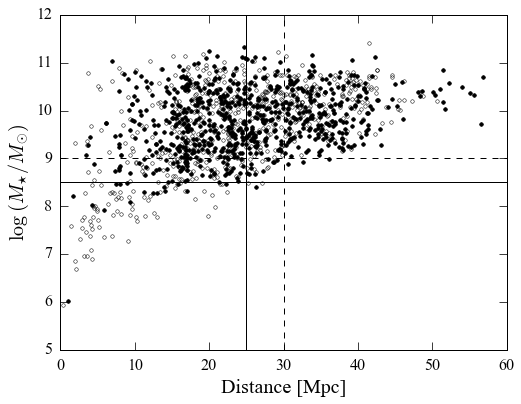

In [20]:
plt.plot(s4gdata.dist, s4gdata.logmstar, 'ko', mfc='None', mec='k',ms=3.5)
plt.plot(s4gdata.dist[ii_barred], s4gdata.logmstar[ii_barred], 'ko',ms=3.5)
plt.axvline(25)
plt.axvline(30, ls='--')
plt.axhline(8.5)
plt.axhline(9, ls='--')
xlim(0,60)
plt.xlabel("Distance [Mpc]"); plt.ylabel(xtmstar)
if savePlots: plt.savefig(plotDir+"logMstar-vs-distance.pdf")

### Figure 1 (right panel): $R_{25}$ vs distance for S4G spirals

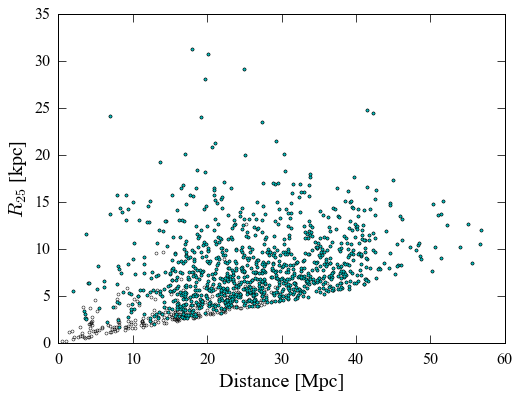

In [18]:
# define extra subsample for plot: all spirals with log(M_star) >= 9
ii_logmstar9 = [i for i in ii_spirals if s4gdata.logmstar[i] >= 9]

plot(s4gdata.dist[ii_spirals], s4gdata.R25_kpc[ii_spirals], 'ko', mfc='None', mec='k',ms=3)
plot(s4gdata.dist[ii_logmstar9], s4gdata.R25_kpc[ii_logmstar9], 'co', ms=3)
xlim(0,60)
xlabel("Distance [Mpc]"); ylabel(ytR25_kpc)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"R25-vs-distance.pdf")

### Figure 2 (left panel): $g - r$ vs stellar mass

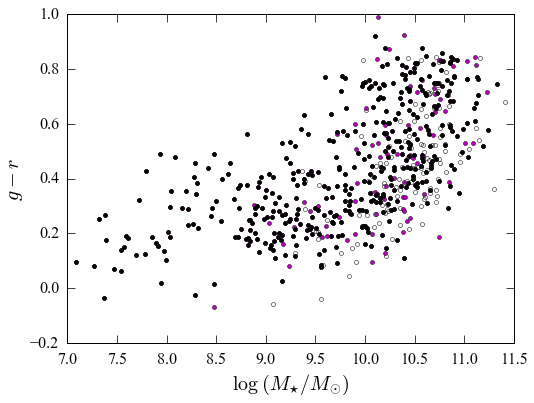

In [25]:
# define extra subsamples for plot: galaxies with valid B-V_tc values; subsets at different distances
ii_bmv_good = [i for i in range(nDisksTotal) if s4gdata.BmV_tc[i] > -2]
iii30 = [i for i in ii_bmv_good if s4gdata.dist[i] <= 30]
iii25 = [i for i in ii_bmv_good if s4gdata.dist[i] <= 25]
iii_larger = [i for i in ii_bmv_good if s4gdata.dist[i] > 30]

plot(s4gdata.logmstar[iii_larger], s4gdata.gmr_tc[iii_larger], 'o', mfc='None', ms=4)
plot(s4gdata.logmstar[iii30], s4gdata.gmr_tc[iii30], 'mo', ms=4)
plot(s4gdata.logmstar[iii25], s4gdata.gmr_tc[iii25], 'ko', ms=4)
xlabel(xtmstar); ylabel(xtgmr)
xlim(7,11.5)
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"gmr-vs-logmstar.pdf")

### Figure 2 (right panel): Gas mass ratio $f_{\rm gas}$ vs stellar mass

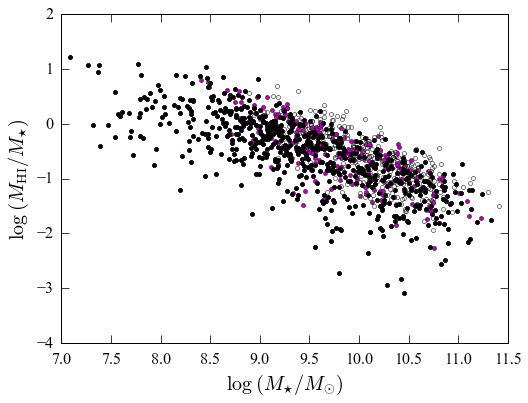

In [24]:
# define extra subsamples for plot: galaxies with valid H_I meassurements; subsets at different distances
iii25 = [i for i in ii_spirals if s4gdata.M_HI[i] < 1.0e40 and s4gdata.dist[i] <= 25]
iii30 = [i for i in ii_spirals if s4gdata.M_HI[i] < 1.0e40 and s4gdata.dist[i] <= 30]
iii_larger = [i for i in ii_spirals if s4gdata.M_HI[i] < 1.0e40 and s4gdata.dist[i] > 30]

plot(s4gdata.logmstar[iii_larger], s4gdata.logfgas[iii_larger], 'o', mfc='None', ms=4)
plot(s4gdata.logmstar[iii30], s4gdata.logfgas[iii30], 'mo', ms=4)
plot(s4gdata.logmstar[iii25], s4gdata.logfgas[iii25], 'ko', ms=4)
xlabel(xtmstar); ylabel(xtfgas)
xlim(7,11.5)
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"logfgas-vs-logmstar.pdf")

### Figure 4: Histogram of stellar masses in different subsamples

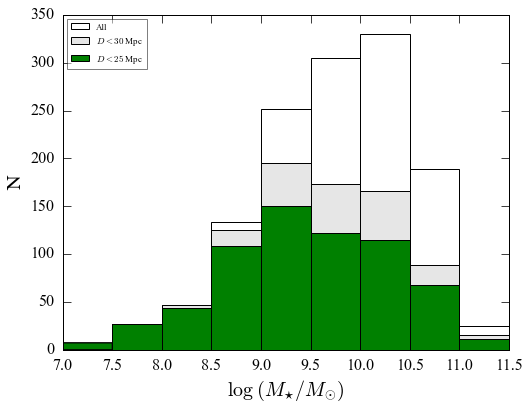

In [21]:
hist(s4gdata.logmstar, bins=np.arange(7,12,0.5), color='1.0', label="All")
hist(s4gdata.logmstar[ii_all_limited2], bins=np.arange(7,12,0.5), color='0.9', label=r"$D < 30$ Mpc")
hist(s4gdata.logmstar[ii_all_limited1], bins=np.arange(7,12,0.5), color='g', label=r"$D < 25$ Mpc")
xlabel(xtmstar);ylabel("N")
legend(fontsize=9, loc='upper left', framealpha=0.5)
if savePlots: savefig(plotDir+"logmstar_hist.pdf")

### Figure 5: Bar fraction as function of stellar mass, color, gas mass fraction

The code here is for the six individual panels of the figure

#### Figure 5 (upper left panel): Bar frequency vs stellar mass

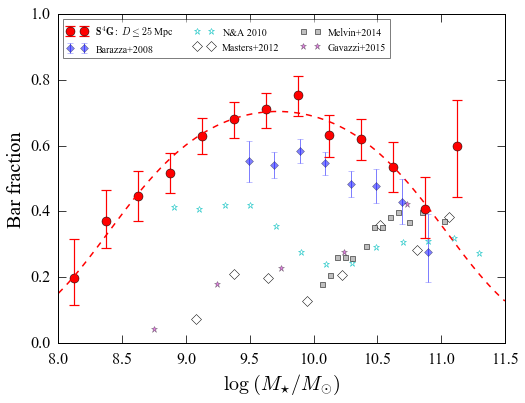

In [33]:
# load Barazza+2008 bar frequencies
logmstar_b08,fbar_b08,fbar_e_low_b08,fbar_e_high_b08 = GetBarazzaData(baseDir+"f_bar_trends-from-literature/fbar-vs-logmstar_barazza+2008.txt")

# load other SDSS-based bar frequencies
logmstar_na10,fbar_na10 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-logMstar_nair-abraham2010.txt")
logmstar_m12,fbar_m12 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-logmstar_masters+2012.txt")
logmstar_m14,fbar_m14 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-logmstar_melvin+2014.txt")
logmstar_g15,fbar_g15 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-logmstar_gavazzi+2015.txt")

# quadratic logistic fit (using weights) -- see R notebook s4gbars_R_logistic-regression.ipynb
# for determination of parameters
logistic_params = [-82.2446, 17.1052, -0.8801]
mm = np.arange(8.0,11.51,0.01)
logistic_fit2w = logistic_polyn(mm, logistic_params)

# plot SDSS-based bar frequencies
plt.plot(logmstar_na10, fbar_na10, '*', mfc="None",mec='c', ms=7,label='N&A 2010')
plt.plot(logmstar_m12, fbar_m12, 'D', mfc="None",mec='k', ms=7,label='Masters+2012')
plt.plot(logmstar_m14, fbar_m14, 's', mfc="0.75",mec='k', ms=5,label='Melvin+2014')
plt.plot(logmstar_g15, fbar_g15, '*', color='m', alpha=0.5, ms=7,label='Gavazzi+2015')
ss1_bold = r"$\mathbf{S^{4}G:}$ $D \leq 25$ Mpc"

# plot S4G bar frequencies and quadratic logistic fit
pu.PlotFrequencyWithWeights(s4gdata.logmstar, s4gdata.w25, ii_barred_limited1, ii_unbarred_limited1, 8.0, 11.3,0.25, fmt='ro', ms=9, noErase=True, label=ss1_bold)
plt.plot(mm, logistic_fit2w, 'r--', lw=1.5)
plt.errorbar(logmstar_b08, fbar_b08, yerr=[fbar_e_low_b08,fbar_e_high_b08], fmt='bD',alpha=0.5, label='Barazza+2008')
plt.ylim(0,1)
plt.xlabel(xtmstar); plt.ylabel('Bar fraction')

# re-order labels in legend
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()
handles = [handles[4], handles[5], handles[0], handles[1], handles[2], handles[3]]
labels = [labels[4], labels[5], labels[0], labels[1], labels[2], labels[3]]
legend(handles, labels, loc="upper left", fontsize=10, ncol=3, framealpha=0.5)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"fbar-vs-logmstar.pdf")

#### Figure 5 (upper right panel): SB and SAB frequencies vs stellar mass

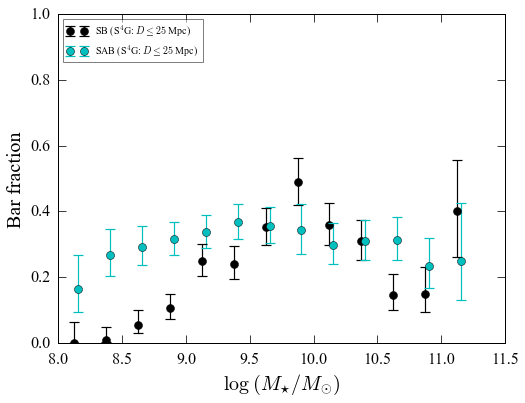

In [35]:
pu.PlotFrequencyWithWeights(s4gdata.logmstar, s4gdata.w25, ii_SB_limited1, ii_nonSB_limited1, 8.0, 11.3, 0.25, fmt='ko',ms=8, label=r'SB (S$^{4}$G: $D \leq 25$ Mpc)')
pu.PlotFrequencyWithWeights(s4gdata.logmstar, s4gdata.w25, ii_SAB_limited1, ii_nonSAB_limited1, 8.0, 11.3, 0.25, offset=0.03, fmt='co', ms=8, noErase=True, label=r'SAB (S$^{4}$G: $D \leq 25$ Mpc)')
plt.ylim(0,1)
plt.xlabel(xtmstar); plt.ylabel('Bar fraction')
legend(fontsize=10, loc='upper left', framealpha=0.5)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"fSB-fSAB-vs-logmstar.pdf")

#### Figure 5 (middle left panel): Bar frequency vs color

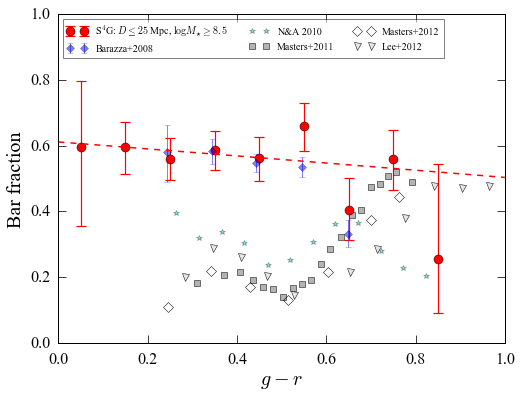

In [45]:
gmr_b08,fbar_b08,fbar_e_low_b08,fbar_e_high_b08 = GetBarazzaData(baseDir+"f_bar_trends-from-literature/fbar-vs-gmr_barazza+2008.txt")
gmr_na10,fbar_na10 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-gmr_nair-abraham2010.txt")
gmr_m11,fbar_m11 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-gmr_masters+2011.txt")
gmr_m12,fbar_m12 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-gmr_masters+2012.txt")
gmr_lee12,fbar_lee12 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-gmr_lee+2012.txt")

# calculate weights: product of color and V/V_max weights
ww25 = s4gdata.weight_BmVtc * s4gdata.w25
ww30 = s4gdata.weight_BmVtc * s4gdata.w30

plt.plot(gmr_na10, fbar_na10, '*', color='c',alpha=0.5, label='N&A 2010')
plt.plot(gmr_m11, fbar_m11, 's', color='0.7', label='Masters+2011')
plt.plot(gmr_m12, fbar_m12, 'D', mfc="None",mec='k', ms=7, label='Masters+2012')
plt.plot(gmr_lee12, fbar_lee12, 'v', mfc="0.9", mec='k', ms=7, label='Lee+2012')
pu.PlotFrequencyWithWeights(s4gdata.gmr_tc, ww25, ii_barred_limited1_m8_5, ii_unbarred_limited1_m8_5, -0.2,1.0,0.1, noErase=True, fmt='ro', ms=9, label=ss1b)
plt.errorbar(gmr_b08, fbar_b08, yerr=[fbar_e_low_b08,fbar_e_high_b08], fmt='bD',alpha=0.5, label='Barazza+2008')
# linear logistic regression for S4G galaxies
gmrvect = np.arange(0,1.1, 0.1)
plot(gmrvect, logistic_lin(gmrvect, 0.4544, -0.4394), 'r--', lw=1.5)
plt.xlabel(xtgmr); plt.ylabel('Bar fraction')
xlim(0,1);ylim(0,1)

# re-order labels in legend
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()
handles = [handles[4], handles[5], handles[0], handles[1], handles[2], handles[3]]
labels = [labels[4], labels[5], labels[0], labels[1], labels[2], labels[3]]
legend(handles, labels, loc="upper left", fontsize=10, ncol=3, framealpha=0.5)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"fbar-vs-gmr_corrected_all.pdf")

#### Figure 5 (middle right panel): SB and SAB frequencies vs color

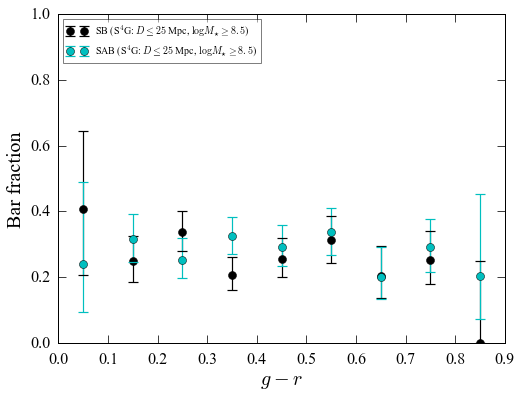

In [42]:
pu.PlotFrequencyWithWeights(s4gdata.gmr_tc, ww25, ii_SB_limited1_m8_5, ii_nonSB_limited1_m8_5, -0.2,1,0.1, fmt='ko', ms=8, label="SB ("+ss1b+")")
pu.PlotFrequencyWithWeights(s4gdata.gmr_tc, ww25, ii_SAB_limited1_m8_5, ii_nonSAB_limited1_m8_5, -0.2,1,0.1, fmt='co', ms=8, noErase=True, label="SAB ("+ss1b+")")
plt.ylim(0,1)
plt.xlabel(xtgmr); plt.ylabel('Bar fraction')
legend(loc="upper left", fontsize=10, framealpha=0.5)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"fSB-fSAB-vs-gmr_corrected.pdf")

#### Figure 5 (lower left panel): Bar frequency vs gas mass ratio

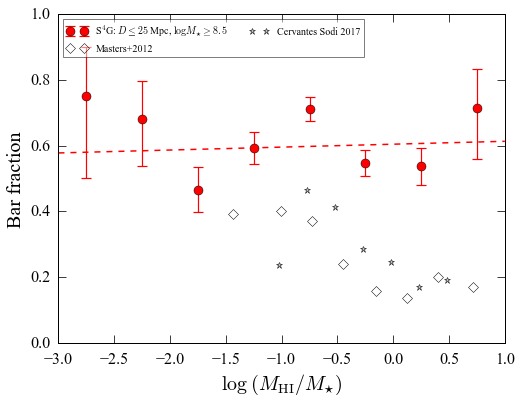

In [44]:
logfgas_m12,fbar_m12 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-logfgas_masters+2012.txt")
logfgas_cs17_raw,fbar_cs17 = profiles.ReadProfile(baseDir+"f_bar_trends-from-literature/fbar-vs-logfgas_cervantes_sodi2017.txt")
# correct CS17 values from log M_{HI + He}/M_{star} to log M_{HI}/M_{star}
logfgas_cs17 = logfgas_cs17_raw - 0.146

plt.clf();pu.PlotFrequencyWithWeights(s4gdata.logfgas, s4gdata.w25, ii_barred_limited1_m8_5, ii_unbarred_limited1_m8_5, -3,2,0.5, fmt='ro', ms=9, label=ss1b)
plt.plot(logfgas_m12, fbar_m12, 'D', mfc="None",mec='k', ms=7,label='Masters+2012')
plt.plot(logfgas_cs17, fbar_cs17, '*', color='0.75', ms=7,label='Cervantes Sodi 2017')
# linear logistic regression for S4G galaxies
fgasvect = np.arange(-3, 1.01, 0.01)
plot(fgasvect, logistic_lin(fgasvect, 0.42456, 0.03684), 'r--', lw=1.5)
plt.xlabel(xtfgas);plt.ylabel('Bar fraction')
plt.ylim(0,1);plt.xlim(-3,1)

# re-order labels in legend
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]
legend(handles, labels, loc="upper left", fontsize=10, ncol=2, framealpha=0.5)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: savefig(plotDir+"fbar-vs-fgas.pdf")

#### Figure 5 (lower right panel): SB and SAB frequencies vs gas mass ratio

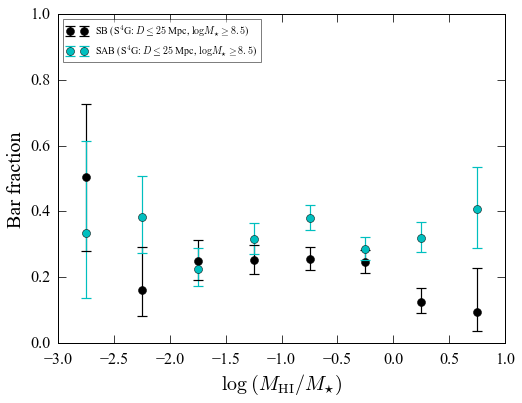

In [46]:
pu.PlotFrequencyWithWeights(s4gdata.logfgas, s4gdata.w25, ii_SB_limited1_m8_5, ii_nonSB_limited1_m8_5, -3,1.5,0.5, fmt='ko', ms=8, label="SB ("+ss1b+")")
pu.PlotFrequencyWithWeights(s4gdata.logfgas, s4gdata.w25, ii_SAB_limited1_m8_5, ii_nonSAB_limited1_m8_5, -3,1.5,0.5, fmt='co', ms=8, noErase=True, label="SAB ("+ss1b+")")
plt.legend(loc='upper left',fontsize=10, framealpha=0.5)
plt.ylim(0,1);xlim(-3,1)
plt.xlabel(xtfgas); plt.ylabel('Bar fraction')
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"fSB-fSAB-vs-fgas.pdf")